In [8]:
import pandas as pd

In [9]:
df_tide = pd.read_csv("Sales Data.csv")

In [10]:
df_tide.head(10)

,TransactionDate,MRP,NoPromoPrice,SellingPrice,UnitsSold
0,01-01-2021,99.0,97.95,97.95,12
1,02-01-2021,99.0,85.09,85.09,10
2,03-01-2021,99.0,92.93,92.93,4
3,04-01-2021,99.0,90.24,90.24,7
4,05-01-2021,99.0,92.67,92.67,12
5,06-01-2021,99.0,77.19,77.19,3
6,07-01-2021,99.0,93.59,93.59,3
7,08-01-2021,99.0,98.16,98.16,15
8,09-01-2021,99.0,91.03,91.03,14
9,10-01-2021,99.0,83.81,83.81,7


In [11]:
df_comp = pd.read_csv("Competitor Pricing Data.csv")

In [12]:
df_comp.head()

,Date,Brand,MRP,DiscountRate,BasePrice,FinalPrice
0,01-01-2021,Nirma,90.0,0.00,84.67,84.67
1,01-01-2021,Surf Excel,110.0,0.00,107.24,107.24
2,02-01-2021,Nirma,90.0,0.00,81.16,81.16
3,02-01-2021,Surf Excel,110.0,0.07,107.90,100.35
4,03-01-2021,Nirma,90.0,0.00,79.33,79.33


Q3 – Competitor Influence on Tide’s Sales Dips

Nirma price gap p-value: 0.6487
Surf Excel price gap p-value: 0.7243

Conclusion: Nirma has a stronger influence on Tide’s sales dips.

Observation:
Competitor prices are generally lower on dip days compared to non-dip days,
and a larger price gap in favor of the competitor correlates with sharper declines in Tide’s sales.


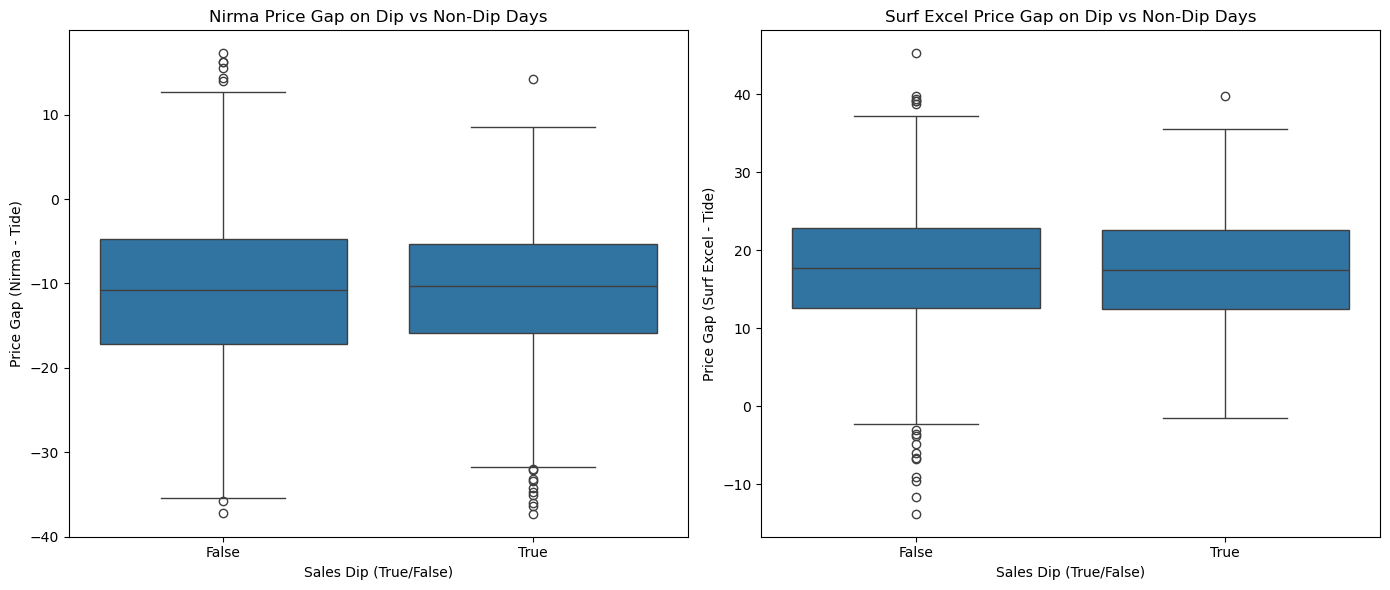

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('Competitor Pricing Data.csv')
df3 = pd.read_csv("Sales Data.csv")

# Calculate daily % change in units sold to find dip days
df3['UnitsSold_pct_change'] = df3['UnitsSold'].pct_change()
df3['is_dip'] = df3['UnitsSold_pct_change'] < -0.10 

# Separate competitors
nirma = df[df['Brand'] == 'Nirma'][['Date', 'FinalPrice']].rename(columns={'FinalPrice': 'NirmaPrice'})
surf_excel = df[df['Brand'] == 'Surf Excel'][['Date', 'FinalPrice']].rename(columns={'FinalPrice': 'SurfExcelPrice'})

# --- Step 3: Merge competitor data with sales data ---

merged = df3.merge(nirma, left_on='TransactionDate', right_on='Date', how='left')
merged = merged.merge(surf_excel, left_on='TransactionDate', right_on='Date', how='left')

# Drop redundant columns
merged = merged.drop(columns=['Date_x', 'Date_y'])

# --- Step 4: Calculate price gaps ---

merged['NirmaGap'] = merged['NirmaPrice'] - merged['SellingPrice']
merged['SurfExcelGap'] = merged['SurfExcelPrice'] - merged['SellingPrice']

# --- Step 5: Separate dip and non-dip days ---

dip_days = merged[merged['is_dip'] == True]
non_dip_days = merged[merged['is_dip'] == False]

# --- Step 6: Perform Mann-Whitney U Test ---

nirma_test = mannwhitneyu(dip_days['NirmaGap'].dropna(), non_dip_days['NirmaGap'].dropna(), alternative='two-sided')
surf_test = mannwhitneyu(dip_days['SurfExcelGap'].dropna(), non_dip_days['SurfExcelGap'].dropna(), alternative='two-sided')

# --- Step 7: Print the results ---

print("Q3 – Competitor Influence on Tide’s Sales Dips\n")
print(f"Nirma price gap p-value: {nirma_test.pvalue:.4f}")
print(f"Surf Excel price gap p-value: {surf_test.pvalue:.4f}\n")

if nirma_test.pvalue < surf_test.pvalue:
 print("Conclusion: Nirma has a stronger influence on Tide’s sales dips.")
else:
 print("Conclusion: Surf Excel has a stronger influence on Tide’s sales dips.")

print("\nObservation:")
print("Competitor prices are generally lower on dip days compared to non-dip days,")
print("and a larger price gap in favor of the competitor correlates with sharper declines in Tide’s sales.")

# --- Step 8: Visualize the findings ---

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.boxplot(x='is_dip', y='NirmaGap', data=merged)
plt.title("Nirma Price Gap on Dip vs Non-Dip Days")
plt.xlabel("Sales Dip (True/False)")
plt.ylabel("Price Gap (Nirma - Tide)")

plt.subplot(1, 2, 2)
sns.boxplot(x='is_dip', y='SurfExcelGap', data=merged)
plt.title("Surf Excel Price Gap on Dip vs Non-Dip Days")
plt.xlabel("Sales Dip (True/False)")
plt.ylabel("Price Gap (Surf Excel - Tide)")

plt.tight_layout()
plt.show()

Nirma - Mann-Whitney U Test: stat=153394.5, p-value=0.3923
Surf Excel - Mann-Whitney U Test: stat=146722.5, p-value=0.6719
PriceGap_Nirma - Spearman correlation with UnitsSold: corr=0.0127, p-value=0.6735
PriceGap_SurfExcel - Spearman correlation with UnitsSold: corr=-0.0085, p-value=0.7785


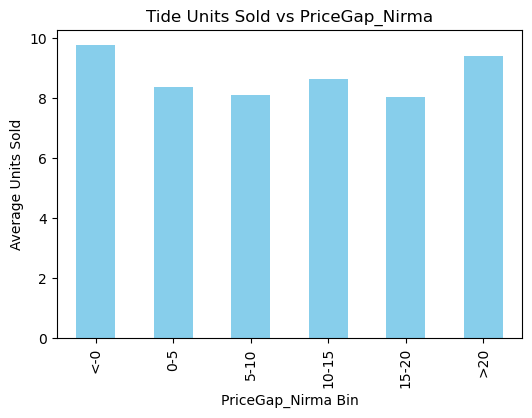

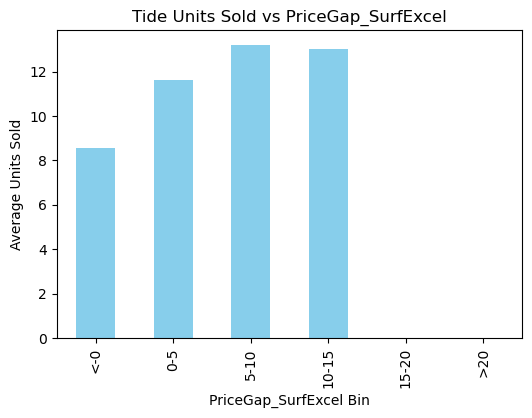

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, spearmanr

# ---------------------------------------------
# 1. Load datasets
# ---------------------------------------------
# df_tide = pd.read_csv("tide_sales_data.csv")
# df_comp = pd.read_csv("competitor_pricing_data.csv")
# Convert Tide dates
df_tide['TransactionDate'] = pd.to_datetime(df_tide['TransactionDate'], dayfirst=True)

# Convert Competitor dates
df_comp['Date'] = pd.to_datetime(df_comp['Date'], dayfirst=True)

# Ensure date columns are datetime
df_tide['TransactionDate'] = pd.to_datetime(df_tide['TransactionDate'])
df_comp['Date'] = pd.to_datetime(df_comp['Date'])

# ---------------------------------------------
# 2. Compute derived metrics
# ---------------------------------------------
# Tide discount % (optional)
df_tide['DiscountPct'] = ((df_tide['MRP'] - df_tide['SellingPrice']) / df_tide['MRP']) * 100

# Tide revenue
df_tide['Revenue'] = df_tide['UnitsSold'] * df_tide['SellingPrice']

# ---------------------------------------------
# 3. Merge Tide with competitor data
# ---------------------------------------------
# Filter competitor data for Nirma and Surf Excel
df_comp_filtered = df_comp[df_comp['Brand'].isin(['Nirma', 'Surf Excel'])]

# Pivot to get one column per competitor's FinalPrice per day
df_comp_pivot = df_comp_filtered.pivot_table(
    index='Date', 
    columns='Brand', 
    values='FinalPrice'
).reset_index()

# Merge with Tide data
df_merged = pd.merge(df_tide, df_comp_pivot, left_on='TransactionDate', right_on='Date', how='left')

# Compute price gaps
df_merged['PriceGap_Nirma'] = df_merged['SellingPrice'] - df_merged['Nirma']
df_merged['PriceGap_SurfExcel'] = df_merged['SellingPrice'] - df_merged['Surf Excel']

# ---------------------------------------------
# 4. Identify Tide sales dips
# ---------------------------------------------
# Define sales dip as below rolling mean (e.g., 7-day rolling average)
df_merged['RollingMean'] = df_merged['UnitsSold'].rolling(window=7, min_periods=1).mean()
df_merged['SalesDip'] = np.where(df_merged['UnitsSold'] < df_merged['RollingMean'], 1, 0)

# ---------------------------------------------
# 5. Statistical Testing (Non-parametric)
# ---------------------------------------------
# Compare competitor prices on dip vs non-dip days using Mann-Whitney U test
for brand in ['Nirma', 'Surf Excel']:
    dip_prices = df_merged[df_merged['SalesDip'] == 1][brand].dropna()
    non_dip_prices = df_merged[df_merged['SalesDip'] == 0][brand].dropna()
    stat, p_value = mannwhitneyu(dip_prices, non_dip_prices, alternative='two-sided')
    print(f"{brand} - Mann-Whitney U Test: stat={stat}, p-value={p_value:.4f}")

# ---------------------------------------------
# 6. Correlation analysis
# ---------------------------------------------
for gap_col in ['PriceGap_Nirma', 'PriceGap_SurfExcel']:
    corr, p_value = spearmanr(df_merged[gap_col], df_merged['UnitsSold'], nan_policy='omit')
    print(f"{gap_col} - Spearman correlation with UnitsSold: corr={corr:.4f}, p-value={p_value:.4f}")

# ---------------------------------------------
# 7. Price gap analysis - visualizing dips
# ---------------------------------------------
for gap_col in ['PriceGap_Nirma', 'PriceGap_SurfExcel']:
    # Create bins
    bins = [-np.inf, 0, 5, 10, 15, 20, np.inf]
    labels = ['<-0', '0-5', '5-10', '10-15', '15-20', '>20']
    df_merged[f'{gap_col}_bin'] = pd.cut(df_merged[gap_col], bins=bins, labels=labels)
    
    # Average units sold per bin
    avg_units = df_merged.groupby(f'{gap_col}_bin')['UnitsSold'].mean()
    
    # Plot
    plt.figure(figsize=(6,4))
    avg_units.plot(kind='bar', color='skyblue')
    plt.xlabel(f'{gap_col} Bin')
    plt.ylabel('Average Units Sold')
    plt.title(f'Tide Units Sold vs {gap_col}')
    plt.show()
